# Black-Scholes PDE: Crank-Nicolson for Valuing a European Call Option

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math as m
import time 

## The Thomas Algorithm
The thomas algorithm is a more computationally efficient way to solve for the unknowns as compared to matrix inversion (works via LU decomposition).

In [3]:
# Define the tridiagonal matrix solver algorithm for BLACK-SCHOLES EQUATION FORMAT
'''
For Tx = d
Inputs:
    - a = lower triangular vector
    - b = diagonal vector
    - c = upper diagonal vector
    - d = -aV_{i-1}^n + (1 + b)V_i^n - cV_{i+1}^n = constant term of knowns for share prices (i-1, i, i+1) at time n
Output:
    - unew = updated v values over space for time n+1
'''
def TDMA(a,b,c,d):
    n = len(d)
    e = np.zeros(n-1)
    f = np.zeros(n)
    V = np.zeros(n)
    
    e[0] = c[0]/b[0]
    f[0] = d[0]/b[0]
    for i in range(1,n-1):
        e[i] = c[i]/(b[i] - a[i]*e[i-1])
    for i in range(1,n):
        f[i] = (d[i] - a[i]*f[i-1])/(b[i] - a[i]*e[i-1])
    
    V[n-1] = f[n-1]
    for i in range(n-1,0,-1):
        V[i-1] = f[i-1] - e[i-1]*V[i]
    return V

## Call Option  Parameters

In [4]:
### // CALL OPTION PARAMETERS /// ###
sig = 0.15 # volatility (std deviation of log returns)
K = 10 # dollars
T = 2 # years
r = 0.02 # yearly risk free interest rate

## Analytical Solution

In [5]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import math
#import sympy as sy

def erf(x):
    if isinstance(x, (int, float)):
        erf = m.erf(x)
    else:
        erf = np.array([m.erf(x) for x in x])
        
    return erf


# function for N(x) - normal CDF
def N(x) :
    return 0.5*(erf(x/np.sqrt(2)) + 1)


'''
# function to calculate the analytical solution to the black scholes equation for a european call given parameters
# INPUTS : 
    - S = stock price (vector)
    - t = time
    - sig = volatility 
    - K = strike price 
    - T = expiry time 
    - r = risk free rate 
    - N = Cumulative normal distribution function (defined above)
OUTPUTS : 
    - Analytical solution for European Call
'''
def BS_analytic_point_S(S, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    S1=S[0]
    ECall1 = np.array([0])
    
    S2=S[1:]
    
    def d1(S):
        return (np.log(S/K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5)) 

    def d2(S):
        return (np.log(S/K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
            
    ECall2 = S2*N(d1(S2)) - K*np.exp(-r*(T-t))*N(d2(S2))
    
    ECall = np.concatenate([ECall1, ECall2])
    
    return ECall

'''
Same as above, now considering transformed Z grid where z = lnS.
'''

def BS_analytic_point_Z(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    ECall = np.where(np.exp(Z) == 0, 0, np.exp(Z)*N(d1(Z)) - K*np.exp(-r*(T-t))*N(d2(Z)))
    
    return ECall


'''
Same as above, now considering transformed Z grid where z = lnS - (r-0.5*sigma^2)*t i.e. the diffusion transformation.
'''
def BS_analytic_point_D(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z + (r - 0.5*sig**2)*t - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z + (r - 0.5*sig**2)*t - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5)) # r terms cancel in t
            
    ECall = np.where(np.exp(Z + (r - 0.5*sig**2)*t) == 0, 0, np.exp(Z + (r - 0.5*sig**2)*t) * N(d1(Z)) - K * np.exp(-r*(T - t)) * N(d2(Z)))
            
    return ECall


'''
Function to calculate analytic Black-Scholes solution given a grid in share price and values specifying the time grid.
INPUTS:
    - S = 1D array of S grid over time (entries = S grid values)
    - dt = time step
    - nt = total number of timesteps
OUTPUT:
    - 2D array of analytical solution over grid values
'''
# function BSASEC for grid of S and t
def BSa_S(S, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(S),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(S - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_S(S=S, t=T - n*dt)
    
    return Asol


def BSa_Z(Z, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(Z),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(np.exp(Z) - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_Z(Z=Z, t=T - n*dt)
    
    return Asol


'''
Function BSASEC for grid of S and t
INPUTS:
    - Z = 1D array of Z grid that, when transformed back to S, moves over time (row = S grid values, column = time) 
          with Z = lnS - (r-0.5*sig^2)*t this implies S = exp[Z + (r-0.5*sig^2)*t]
    - dt = time step
    - nt = total number of timesteps
OUTPUT:
    - 2D array of analytical solution over grid values
'''
def BSa_D(Z, dt, nt):
    # empty solution matrix
    Asol = np.zeros((len(Z),nt+1))
    
    # Initial Conditions
    VIC = np.maximum(np.exp(Z + (r - 0.5*sig**2)*T) - K, 0)
    Asol[:,0] = VIC # corresponding to t = T
    
    # Solving backwards in time
    for n in range(1, nt+1):
        Asol[:,n] = BS_analytic_point_D(Z=Z, t=T - n*dt)
    
    return Asol

## Discretization Error Matrix Calculator

In [6]:
# Define function that, given a numerical solution, will provide the discretization errors
def DErrors_S(Nsol, S, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(S),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_S(S, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr


def DErrors_Z(Nsol, Z, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_Z(Z, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr


def DErrors_D(Nsol, Z, dt, nt):
    # Initialise error matrix
    Derr = np.zeros((len(Z),nt+1))
    
    # Calculate analytic solutions for grid
    Asol = BSa_D(Z, dt, nt)
    
    # Calculate errors
    Derr = np.subtract(Nsol, Asol)
    return Derr

# 1. Solving in $(S, t)$ space
The PDE to be explored is the Black-Scholes PDE modelling the payoff(value) of a financial derivative,

$${\partial V \over \partial t} + {1 \over 2}\sigma^2S^2{\partial^2 V \over \partial S^2} + rS{\partial V \over \partial S} - rV = 0,$$

considering a Call Option with:
- Share volatility, $\sigma$
- 1-year risk free interest rate, $r$
- Expiry time, $T$ (in years)
- Strike price, $K$
- Share price, $S$ (of course this also varies with time)

The Initial and Boundary conditions are:
 
(1) $V(S,\;T) = \max(S-K,\;0)$

(2) $V(0, t) = 0,\;\forall\,t$ 

(3) $as\,S \rightarrow \infty,\; V(S, t) = S - Ke^{-r(T-t)} \approx S$


Notes on conditions:
- (1) The initial condition becomes the known final payoff function, as the PDE is solved backwards in time: The payoff/value is known at expiry, and so the finite difference scheme is applied taking steps from t = T back to t = 0.
- (2) When a share drops below a certain price for a long enough period of time (below $ \$ $1 for 30 days on the Nasdaq) the stock will be delisted. In this case, trading of options moves to the OTC market and is limited to closing positions. For a call option to regain any value the company must therefore avoid bankruptcy, get relisted on the exchange, and increase in value above the strike price, all before the time till expiry $(T-t)$. Generally, this is very unlikely, and it is safe to assume that the value of the call option will be zero.
- (3) For large enough $S>>K$ it is unlikely that the share price will fall below K (a black swan event) so the value of the call option is said to be the payoff function with the strike price discounted to the current time t, i.e. the present value of that money. Another way to view this is that we are assuming that $S(t)$ has a growth rate $r$, and discounting the final payoff back to time $t$ for its present value. This assumes a risk-neutral growth of share price S (at rate r) i.e. that $S(T) = Se^{-r(T-t)}$, which is not necessarily accurate. Perhaps it would be better to predict a growth rate $\mu$ of the stock till time T (more accurate than r) such that $S(T) = Se^{\mu(T-t)}$ and then discount the projected call value of payoff such that the present value is $PV(Call) = Se^{(\mu-r)(T-t)} - Ke^{-r(T-t)}$. Alternatively, since the magnitude of the K term is much smaller than S, the boundary value could be approximated as S. Exploring the significance of the boundary on results could be interesting.

## Crank-Nicolson Scheme Derivation

We will solve this PDE numerically with the Finite Difference Crank-Nicolson Scheme, implementing the Tridiagonal Matrix Algorithm (Thomas Algorithm)

- The Thomas algorithm is not always stable, but will be in special cases (e.g. diagonally dominant by rows or columns/symmetric positive definite, (see Higham theorem 9.12) - if general stability is required GE is better.

The Crank-Nicolson scheme is derived by taking a central difference at half step $\Delta t / 2$ in time (second order in $\Delta t)$ and a standard central difference in space (second order in $\Delta y$) at this half step time. The terms evaluated at time $n + 1/2$ from this central difference are then substituted with their fromulation in terms of terms in time $n$ and $n+1$ (adding together the Taylor expansions of times $n$ and $n+1$ about the point $n + 1/2$ and rearranging, truncating at second order in $\Delta t$). Thus, the time derivative is represented by ${\partial V \over \partial t} = (V_i^{n+1}-V_i^n)/\Delta t$, 

The forward time central difference scheme will be:
$\frac{V_i^{n+1}-V_i^n}{\Delta t} + Z_{i-1,i,i+1}^{n} = 0$

The backward time scheme central difference scheme will be:
$\frac{V_i^{n+1}-V_i^n}{\Delta t} + Z_{i-1,i,i+1}^{n+1} = 0$

Taking the average of both equations,

$\frac{V_i^{n+1}-V_i^n}{\Delta t} + {1 \over 2}(Z_{i-1,i,i+1}^{n+1} + Z_{i-1,i,i+1}^{n+1}) = 0$

Thus, rearranging implies that the scheme will be 

$V_i^{n+1} + {\Delta t \over 2}Z_{i-1, i, i+1}^{n+1} = V_i^n - {\Delta t \over 2}Z_{i-1, i, i+1}^{n}.$


#### The tridiagonal system
The above scheme reduces to a tridiagonal system when collecting terms in $n+1$ (knowns) and $n$ (unknowns) - solving backwards in time, such that

$-a_iV_{i-1}^{n} + (1+b_i)V_{i}^{n} - c_iV_{i+1}^{n} = a_iV_{i-1}^{n+1} + (1-b_i)V_{i}^{n+1} + c_iV_{i+1}^{n+1}$

where the known constants are
- $a_i = {\Delta t \over 4}[\frac{\sigma^2S_i^2}{(\Delta S)^2} - \frac{rS_i}{\Delta S}]$
- $b_i = {\Delta t \over 2}[\frac{\sigma^2S_i^2}{(\Delta S)^2} + r]$
- $c_i = {\Delta t \over 4}[\frac{\sigma^2S_i^2}{(\Delta S)^2} + \frac{rS_i}{\Delta S}]$

## Test Case: $\Delta t = 0.001, \Delta S = 0.1$

### Constant Parameters: $S_{min}=0, S_{max}=5000, dS = 0.1, dt = 0.01$

In [316]:
# FOR THE ORIGINAL BLACK-SCHOLES PDE
### // Customizable // ###
iS = 50000 # total number of grid points along S (CHANGE TO TOTAL NUMBER OF STEPS IN S)
Smax = 5000 # maximum share price defining boundary
Smin = 0

### // Fixed for Black-Scholes PDE problem// ###
dS = Smax/float(iS) # may need variable spacing as S boundary is so large (have more points for S near enough K)
dt = 0.01 # fixed time spacing seems reasonable

S = np.linspace(Smin, Smax, iS + 1) #
t0 = T # start time (going backwards)
nt = int(T/dt) # number of steps in time

print(f'dS = {dS} and dt = {dt}')

dS = 0.1 and dt = 0.01


###  Initial Condition and Boundary Conditions
The "initial conditions" will be the payoff/value of the option at expiry, as the change of variables to go from B-S to the diffusion equation results in a backwards in time process. 

(1) $V(S,\;T) = \max(S-K,\;0)$

(2) $V(0, t) = 0,\;\forall\,t$ 

(3) $as\,S \rightarrow \infty,\; V(S, t) = S - Ke^{-r(T-t)} \approx S$. This will be replaced with a numerical maximal value for share price $S_{max}$ to take on the role of the infinite boundary, and will be chosen to be a large enough value that it will accurately reflect the unattainable infinite boundary.

In [317]:
# Initial (final) condition (working backwards) at time t = T
VIC = np.maximum(S - K, 0)

VB1 = 0
VB2 = Smax

# boundary conditions
VIC[0] = VB1
VIC[iS] = VB2

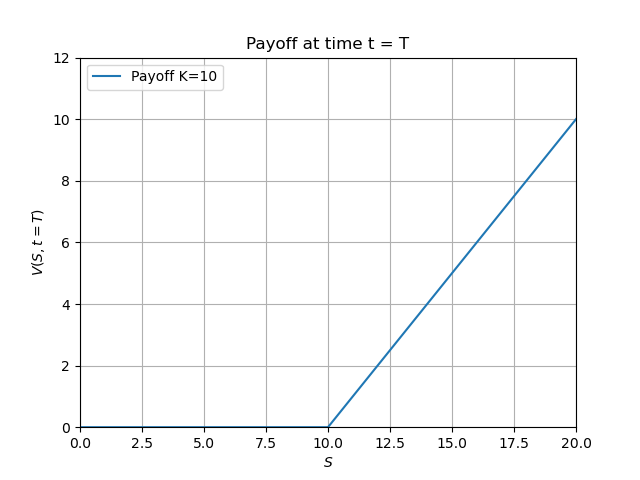

In [318]:
# Visualising initial conditions
plt.figure()
plt.ylim(0, 12)
plt.xlim(0, 2*K)
plt.ylabel('$V(S, t=T)$') # r infront of string necessary if "\" required, else use \\
plt.xlabel('$S$')
plt.grid()
plt.plot(S, VIC, label='Payoff K=10')
plt.legend(loc='upper left')
plt.title("Payoff at time t = T")
plt.show()


### Solving the Tridiagonal System

Here n are the unknown points, and n+1 are known (solving backwards in time).

$-a_iV_{i-1}^{n} + (1+b_i)V_{i}^{n} - c_iV_{i+1}^{n} = a_iV_{i-1}^{n+1} + (1-b_i)V_{i}^{n+1} + c_iV_{i+1}^{n+1} = D_i^{n+1}$

where the known constants are
- $a_i = {\Delta t \over 4}[\frac{\sigma^2S_i^2}{(\Delta S)^2} - \frac{rS_i}{\Delta S}]$
- $b_i = {\Delta t \over 2}[\frac{\sigma^2S_i^2}{(\Delta S)^2} + r]$
- $c_i = {\Delta t \over 4}[\frac{\sigma^2S_i^2}{(\Delta S)^2} + \frac{rS_i}{\Delta S}]$

In [319]:
t0 = time.time()
# Define matrix to store numerical values:
## columns evolve in time, i.e. each column represents the payoff at share price grid values at a certain time
V = np.zeros((iS-1, nt+1)) # includes nS-1 share price points (excluding boundaries) covering all time evaluations
t = T # solving backwards in time starting at T
V[:,0] = VIC[1:iS] # fill first column with ICs (excluding boundaries)


# Arrays for the tridiagonal system: 
# Take i=0, 1, ..., iS share price indices -> i=0 and i=nS-1 excluded (do not need to solve) -> tridiag from i=1, ..., nS-2
# Take j=0, 1, ..., nt in time
d = np.zeros(iS-1)          # RHS needs setting every timestep for C-N -> create empty array to change over time

a = (dt/4 * (sig**2 * np.power(S, 2) / dS**2 - r*S/dS))[1:-1]      # lower-diagonal

b = (dt/2 * (sig**2 * np.power(S, 2) / dS**2 + r))[1:-1]          
bprev = np.ones(iS-1) + b  # diagonal (solving backwards in time)
bknown = np.ones(iS-1) - b  # RHS constant

c = (dt/4 * (sig**2 * np.power(S, 2) / dS**2 + r*S/dS))[1:-1]      # upper off-diagonal


### Solve tridiagonal system for each time step (calculate past V, start with future V at t=0, to t=1, ..., t=it steps backwards)
for j in range(1, nt+1):
    # update RHS vector using current V, taking care with BCs
    # S=0 boundary
    d[0] = bknown[0]*V[0,j-1] + c[0]*V[1,j-1] # +a[0]*Smin + a[0]*Smin from BC, but Smin = 0
    
    # boundaries not involved (d[1], ..., d[nS-4])
    d[1:-1] = a[1:-1]*V[0:-2,j-1] + bknown[1:-1]*V[1:-1,j-1] + c[1:-1]*V[2:,j-1] # space 0,1,2 -> 1,2,3 -> ... -> nS-3, nS-2, nS-1
    
    # S=Sm boundary
    d[-1] = c[-1]*VB2 + (a[-1]*V[-2,j-1] + bknown[-1]*V[-1,j-1] + c[-1]*VB2)
    
    # solve with TDMA
    V[:,j] = TDMA(-a,bprev,-c,d)

t1 = time.time()

print(f'Execution time: {t1-t0}s')

Execution time: 13.982367515563965s


In [242]:
# Matrix of results
# Add the i=0 and i=nS-1 boundary condition values
V0 = np.array([VB1]*(nt+1)) # for i = 0
VnSm1 = np.array([VB2]*(nt+1)) # for i = nS - 1 (= nSm1)
Vsol = np.vstack((V0, V, VnSm1))

In [243]:
# sanity check dimensions and print
print(Vsol.shape)

(50001, 201)


### Plot of Numerical Solution over Time

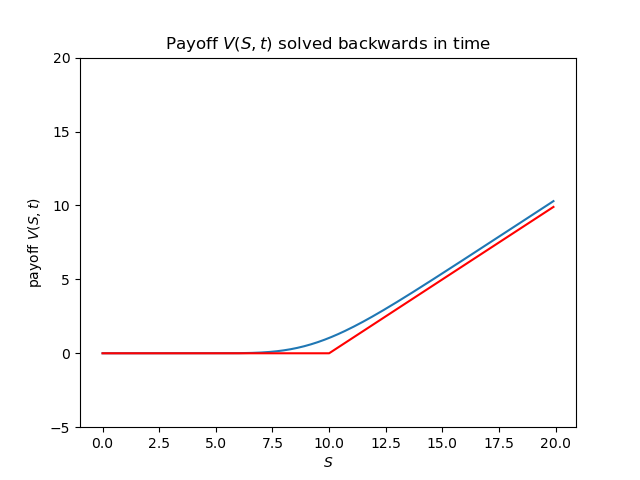

In [244]:
# imports
import celluloid

# figure parameters & initialise
fig = plt.figure()

# initiate camera
animation_camera = celluloid.Camera(fig)

# adjust plot domain
RHS = int(2*K/dS)
Splot = np.linspace(0, Smax, iS+1)[:RHS]


for i in range(nt+1):
    Z = Vsol[:,i][:RHS]
    plt.ylim(-5,20)
    plt.plot(Splot, Z)
    plt.plot(Splot, Vsol[:,0][:RHS], color='r') # add [:RHS]
    plt.title('Payoff $V(S, t)$ solved backwards in time')
    plt.xlabel('$S$')
    plt.ylabel('payoff $V(S, t)$')
    animation_camera.snap()


animation = animation_camera.animate() 
animation.save('BSEuropeanCall-(S,t).mp4')

### Plot of Analytical Solution over Time

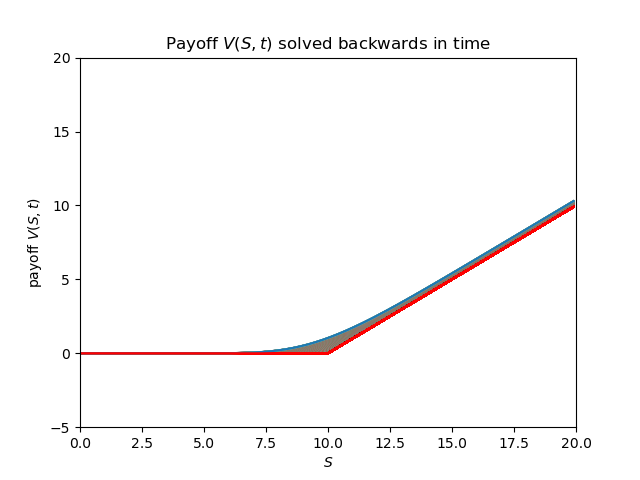

In [245]:
# figure parameters & initialise
fig = plt.figure()

# initiate camera
animation_camera = celluloid.Camera(fig)

# adjust plot domain
RHS = int(2*K/dS)
Splot = np.linspace(0, Smax, iS+1)[:RHS]

ASol = BSa_S(S, dt, nt)

for i in range(nt+1):
    Z = ASol[:,i][:RHS]
    plt.ylim(-5,20)
    plt.xlim(0, 20)
    plt.plot(Splot, Z)
    plt.plot(Splot, ASol[:,0][:RHS], color='r') # add [:RHS]
    plt.title('Payoff $V(S, t)$ solved backwards in time')
    plt.xlabel('$S$')
    plt.ylabel('payoff $V(S, t)$')
    animation_camera.snap()


animation = animation_camera.animate() 

### Matrix inversion solution (as opposed to Thomas Algorithm)

In [246]:
# initialize solution
#V = np.zeros((iS-1, nt+1)) # excluding boundary values
# initial conditions
#V[:,0] = VIC[1:-1]
# boundary values
#VB1 = 0
#VB2 = Smax

#for n in range(1, nt +1):
    # // Build tridiagonal matrix system //
        # TERMS IN CONSTANT
    #ac = (dt/4 * (sig**2 * np.power(S, 2) / dS**2 - r*S/dS))[1:-1]      # lower-diagonal

    #bis = (dt/2 * (sig**2 * np.power(S, 2) / dS**2 + r))[1:-1]          
    #bc = np.ones(iS-1) - bis  # diagonal (solving backwards in time)

    #cc = (dt/4 * (sig**2 * np.power(S, 2) / dS**2 + r*S/dS))[1:-1]      # upper off-diagonal
    
        # DIAGONALS
    #a = -ac
    #b = np.ones(iS-1) + bis
    #c = -cc

        # Creating matrix A
    #A = np.zeros((iS-1,iS-1))
        
    #for i in range(iS-1-1): # excluding last main diagonal element
        #A[i][i] = b[i]
        #A[i+1][i] = a[i]
        #A[i][i+1] = c[i]
        
    #A[-1,-1] = d[-1] # indices -1 and jm-2 are interchangeable here, this is the last diagonal element

    # Defining constant matrix b
    #d = np.zeros(iS-1)
        
    # i = 1 boundary value case
    #d[0] = bc[0]*V[0,n-1] + cc[0]*V[1,n-1]
        
    # i = 2, ..., iS-2
    #d[1:-1] = ac[1:-1]*V[0:-2,n-1] + bc[1:-1]*V[1:-1,n-1] + cc[1:-1]*V[2:,n-1]
        
    # i = iS-1 boundary value case
    #d[-1] = (ac[-1]*V[-2,n-1] + bc[-1]*V[-1,n-1] + cc[-1]*VB2) + cc[-1]*VB2
        
        
    # // Solve for u at next time
    #V[:, n] = np.linalg.solve(A, d) # u_j= 0 and u_jm have BCs so solve for j = 1, ..., jm-1

### Discretization Error Analysis

#### Error matrix

In [247]:
# Discretization error matrix
P1error = DErrors_S(Vsol, S, dt=dt, nt=nt)

In [248]:
# Absolute discretization errors
AP1error = np.abs(P1error)

#### Final Time Error Metrics (present valuation error)

##### 1. Entire share price domain

In [249]:
# Absolute final error values
finErr1 = np.abs(P1error[:,-1])
# MAX ERROR
max_error1 = np.max(finErr1)
print(f'The maximal error is: \n {max_error1}')
max_error_ind1 = np.where(finErr1 == max_error1)[0][0]
print(f'The max error is located at {max_error_ind1}, corresponding to an S value of {max_error_ind1*dS} \n')


# Absolute error for each time
abs_error1 = np.sum(finErr1)
print(f'The absolute sum of errors is: \n {abs_error1}')

The maximal error is: 
 10.13171417119429
The max error is located at 49940, corresponding to an S value of 4994.0 

The absolute sum of errors is: 
 74955.97335921084


##### 2. Realistic share price domain

In [250]:
# Define a cutoff at a large enough S and corresponding Z
Scut = 1000
cutoff = int(Scut / dS)

real_finErr1 = finErr1[:cutoff]
real_max_error1 = np.max(real_finErr1)
print(f'The maximal error is: \n {real_max_error1}')

real_max_error_ind1 = np.where(real_finErr1 == real_max_error1)[0][0]
print(f'The max error is located at {real_max_error_ind1}, corresponding to an S value of {real_max_error_ind1*dS}')


# Absolute error for each time
real_abs_error1 = np.sum(real_finErr1)
print(f'The absolute sum of errors is: \n {real_abs_error1}')

The maximal error is: 
 0.00023219293580822864
The max error is located at 98, corresponding to an S value of 9.8
The absolute sum of errors is: 
 0.009709895258775159


#### Final Time Error Plots

##### 1. Numerical Solution overlaid with Analytic solution at final time

In [251]:
Asol = BSa_S(S, dt=dt, nt=nt)
AsolCurr = Asol[:,-1]
VsolCurr = Vsol[:,-1]

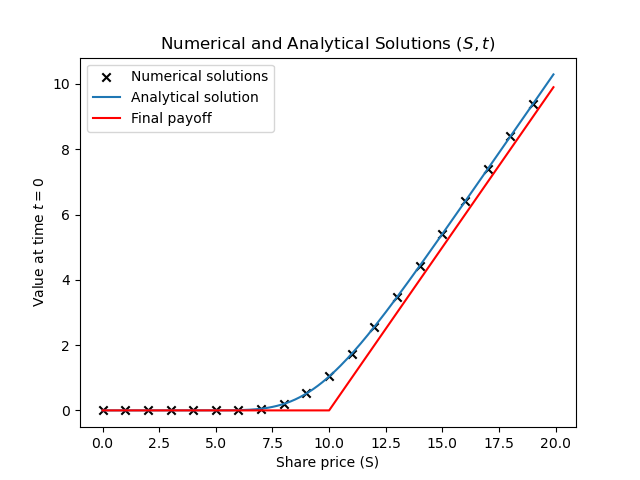

In [252]:
cutoff = int(2*K/dS)
Splot = S[:cutoff]
Vsolplot = VsolCurr[:cutoff]
Asolplot = AsolCurr[:cutoff]
ICplot = Vsol[:,0][:cutoff]

# solutions are of length 300 -> 300 grid points from 0-30, therefore take every tenth point instead
SplotN = Splot[::10]
Vsolplot = Vsolplot[::10]


plt.figure()
plt.scatter(SplotN, Vsolplot, marker='x', color = 'black', label='Numerical solutions')
plt.plot(Splot, Asolplot, label = 'Analytical solution')
plt.plot(Splot, ICplot, color='r', label='Final payoff')
plt.title('Numerical and Analytical Solutions $(S, t)$')
plt.xlabel('Share price (S)')
plt.ylabel('Value at time $t=0$')
plt.legend()
plt.show()

##### 2. Final absolute discretization error over grid

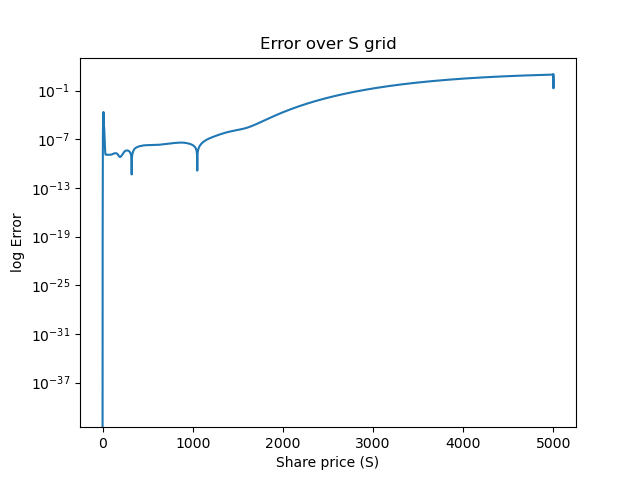

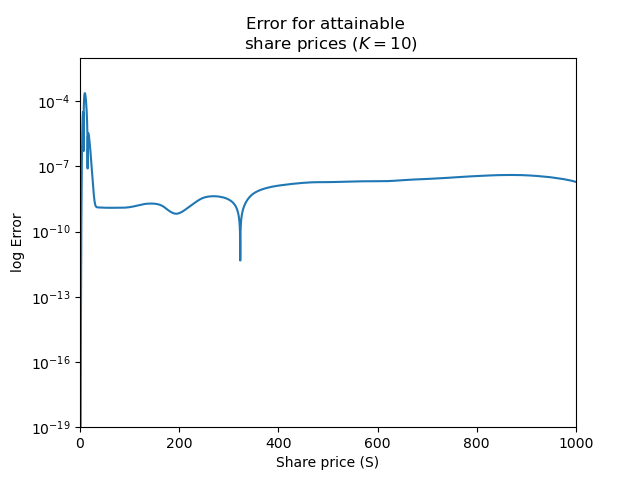

In [295]:
# Entire grid
plt.figure()
plt.semilogy(S, AP1error[:,-1])
plt.title('Error over S grid')
plt.xlabel('Share price (S)')
plt.ylabel('log Error')
plt.show()


# Up to reasonable, but still practically unreachable S = 1000 (relative to strike price K = 10)
plt.figure()
plt.semilogy(S, AP1error[:,-1])
plt.title('Error for attainable \n share prices ($K=10$)')
plt.xlabel('Share price (S)')
plt.ylabel('log Error')
plt.xlim(0, 1000)
plt.ylim(1e-19, 1e-2)
plt.show()

# 2. Solving in $(ln(S), t)$ Space
Transformations:
- $S \rightarrow z = ln(S)$

Effect on PDE:
- ${\partial \over \partial S} \rightarrow \frac{1}{S}{\partial \over \partial z}$
- ${\partial^2 \over \partial S^2} = {\partial \over \partial S}({\partial \over \partial S}) \rightarrow \frac{1}{S^2}{\partial \over \partial z} - \frac{1}{S^2}{\partial \over \partial z}$

which implies that the PDE now becomes

$${\partial V \over \partial t} + {1 \over 2}\sigma^2{\partial^2 V \over \partial z^2} + (r - \frac{1}{2}\sigma^2){\partial V \over \partial z} - rV = 0.$$

Thus, the PDE coefficients no longer depend on S (non-degenerate), and the tridiagonal system coefficients will therefore turn into constants.

#### Tridiagonal system
$-aV_{i-1}^{n} + (1+b)V_{i}^{n} - cV_{i+1}^{n} = aV_{i-1}^{n+1} + (1-b)V_{i}^{n+1} + cV_{i+1}^{n+1}$

where the known constants are (no longer varying with Share price grid point)
- $a_i = {\Delta t \over 4}[\frac{\sigma^2}{(\Delta z)^2} - \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$
- $b_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} + r]$
- $c_i = {\Delta t \over 4}[\frac{\sigma^2}{(\Delta z)^2} + \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$

## Test Case: $\Delta z = 0.00063, \Delta t = 0.01$

### Constant Parameters: $z_{min}=ln(1\times10^{-10}), z_{max}=ln(5000), dz = 0.00063, dt = 0.01$

In [7]:
### // Customizable // ###
iZ = 50000 # total number of grid steps along Z
Smin = 1e-10 # can no longer use Smin = 0 as log(0) = -inf, use a small number as replacement
Smax = 5000 # can use even larger Smax as ln transformation squishes results quicker
Zmin = np.log(Smin) # low boundary
Zmax = np.log(Smax) # high bonudary

### // Fixed for Black-Scholes PDE problem// ###
dZ = (Zmax - Zmin)/float(iZ) # may need variable spacing as S boundary is so large (have more points for S near enough K)
dt = 0.01 # fixed time spacing seems reasonable

Z = np.linspace(Zmin, Zmax, iZ + 1) # Nx total grid points from 0 to L included (combine two np.linspace of different step sizes)
t0 = T # start time (going backwards)
nt = int(T/dt) # number of steps in time

print(f'Stepsizes dz = {dZ} and dt = {dt}')
print(f'lambda = {dt/dZ}')

dzt = dZ
dtt = dt

Stepsizes dz = 0.0006308608824271339 and dt = 0.01
lambda = 15.851355312325975


### Initial and Boundary Conditions

In [8]:
# Initial and boundary conditions
VIC = np.maximum(np.exp(Z) - K, 0)

VB1 = 0
VB2 = Smax

VIC[0] = VB1 # still use zero as the boundary value
VIC[-1] = VB2

### Solving the Tridiagonal System
$-aV_{i-1}^{n} + (1+b)V_{i}^{n} - cV_{i+1}^{n} = aV_{i-1}^{n+1} + (1-b)V_{i}^{n+1} + cV_{i+1}^{n+1}$

where the known constants are (no longer varying with Share price grid point)
- $a_i = {\Delta t \over 4}[\frac{\sigma^2}{(\Delta z)^2} - \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$
- $b_i = {\Delta t \over 2}[\frac{\sigma^2}{(\Delta z)^2} + r]$
- $c_i = {\Delta t \over 4}[\frac{\sigma^2}{(\Delta z)^2} + \frac{(r - \frac{1}{2}\sigma^2)}{\Delta z}]$

In [9]:
# Define solution matrix
V = np.zeros((iZ-1, nt+1))
# add initial conditions in first column
V[:,0] = VIC[1:-1]

In [10]:
t0 = time.time()
# Define tridiagonal system

# constants in system
ac = (dt/4 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
bc = (dt/2 * (sig**2/dZ**2 + r)) # care with 1 +/- b
cc = (dt/4 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

# vectors of tridiagonal
a = - ac * np.ones(iZ-1) # lower diag
b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
c = - cc * np.ones(iZ-1) # upper diag

# check diagonal dominance for thomas algorithm stability
print(f'lower diag values = {ac}')
print(f'diag values = {1 - bc}')
print(f'upper diag values = {cc}')


# empty RHS vector
d = np.zeros(iZ-1)


# iterate over time, note here the middle value has (1 + bc)
for j in range(1, nt+1):
    # left boundary
    d[0] = (ac*VB1 + (1 - bc)*V[0,j-1] + cc*V[1,j-1]) + ac*VB1
    # no boundaries involved
    d[1:-1] = (ac*V[0:-2,j-1] + (1 - bc)*V[1:-1,j-1] + cc*V[2:,j-1])
    # right boundary
    d[-1] = (ac*V[-2,j-1] + (1 - bc)*V[-1,j-1] + cc*VB2) + cc*VB2 #problematic
    
    
    # store solution
    V[:,j] = TDMA(a,b,c,d)

t1 = time.time()

print(f'\n Execution time: {t1-t0}s')

lower diag values = 141.30214935640703
diag values = -281.67374839230547
upper diag values = 141.37149903589847

 Execution time: 14.969767570495605s


In [11]:
# Matrix of results
# Add the i=0 and i=nS-1 boundary condition values
V0 = np.array([VB1]*(nt+1))
ViZ = np.array([VB2]*(nt+1))
Vsol = np.vstack((V0, V, ViZ))

### Plotting Results

#### 1. (lnS, t) Domain

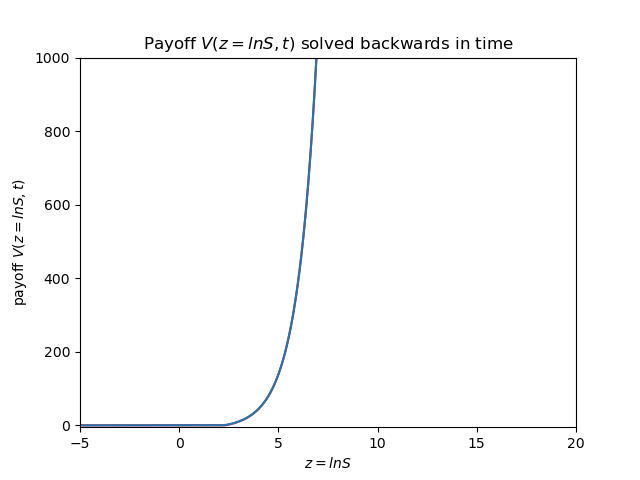

In [12]:
# imports
import celluloid

# figure parameters & initialise
fig = plt.figure()

# initiate camera
animation_camera = celluloid.Camera(fig)


#RHS = int(30/dZ)
#Zplot = np.linspace(Zmin, Zmax, iZ+1)


for n in range(nt+1):
    V_n = Vsol[:,n]
    plt.ylim(-5,1000)
    plt.xlim(-5,20)
    plt.plot(Z, Vsol[:,0], color='r')
    plt.plot(Z, V_n)
    plt.title('Payoff $V(z = lnS, t)$ solved backwards in time')
    plt.xlabel('$z = lnS$')
    plt.ylabel('payoff $V(z = lnS, t)$')
    animation_camera.snap()


animation = animation_camera.animate() 
animation.save('BSEuropeanCall-lnS-zspace.mp4')

#### 2. (S, t) domain

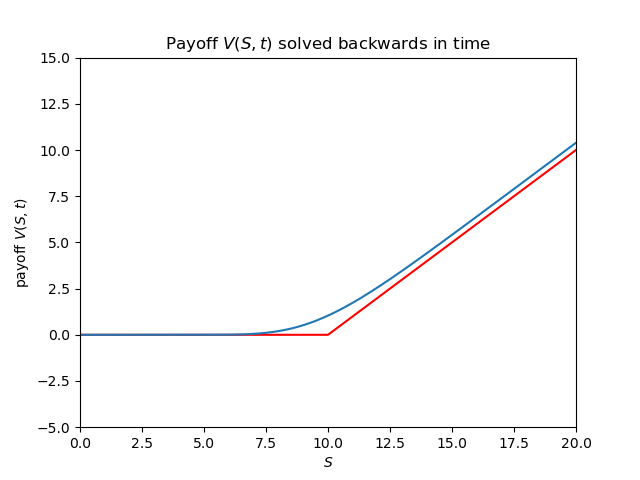

In [13]:
S = np.exp(Z)

# figure parameters & initialise
fig = plt.figure()

# initiate camera
animation_camera = celluloid.Camera(fig)

for i in range(nt+1):
    V_n = Vsol[:,i]
    plt.ylim(-5,15)
    plt.xlim(0,20)
    plt.plot(S, Vsol[:,0], color='r')
    plt.plot(S, V_n)
    plt.title('Payoff $V(S, t)$ solved backwards in time')
    plt.xlabel('$S$')
    plt.ylabel('payoff $V(S, t)$')
    animation_camera.snap()


animation = animation_camera.animate() 
animation.save('BSEuropeanCall-lnS-Sspace.mp4')

### Analytical Solution Plot
This time, a different share price grid in comparison to $(S,t)$ and $(S, \tau)$. Nevertheless, the interpolated Analytical Solutions should be the same, so the plot is still a valid comparison.

### Discretization Error

#### Error matrix

In [264]:
# Discretization errors
P3error = DErrors_Z(Vsol, Z, dt=dt, nt=nt)

In [265]:
# Absolute Discretization errors
AP3error = np.abs(P3error)

#### Error metrics for present time valuation

##### 1. Considering entire $Z \equiv S$ domain

In [266]:
# Absolute final error values
finErr3 = np.abs(P3error[:,-1])
# MAX ERROR
max_error3 = np.max(finErr3)
print(f'The maximal error is: \n {max_error3}')
max_error_ind3 = np.where(finErr3 == max_error3)[0][0]
print(f'The max error is located at {max_error_ind3}, corresponding to a z value of {Zmin + max_error_ind3*dZ}, and S value of {np.exp(Zmin + max_error_ind3*dZ)} \n')


# Absolute error for each time
abs_error3 = np.sum(finErr3)
print(f'The absolute sum of errors is: \n {abs_error3}')

The maximal error is: 
 9.930773113389478
The max error is located at 49998, corresponding to a z value of 8.515931469651381, and S value of 4993.695369356953 

The absolute sum of errors is: 
 2718.277021818988


##### 2. Considering realistically attainable $Z \equiv S$ domain

In [267]:
# Define a cutoff at a large enough S and corresponding Z
Scut = 1000
Zcut = np.log(1000)
cutoff = int((Zcut - Zmin) / dZ)

real_finErr3 = finErr3[:cutoff]
real_max_error3 = np.max(real_finErr3)
print(f'The maximal error is: \n {real_max_error3}')

real_max_error_ind3 = np.where(real_finErr3 == real_max_error3)[0][0]
print(f'The max error is located at {real_max_error_ind3}, corresponding to a z value of {Zmin + real_max_error_ind3*dZ}, and S value of {np.exp(Zmin + real_max_error_ind3*dZ)} \n')


# Absolute error for each time
real_abs_error3 = np.sum(real_finErr3)
print(f'The absolute sum of errors is: \n {real_abs_error3}')



The maximal error is: 
 0.0005186768294898059
The max error is located at 40149, corresponding to a z value of 2.3025826386265393, and S value of 9.999975456355056 

The absolute sum of errors is: 
 0.004890582154040221


#### Error plots

##### 1. Numerical and Analytic Solution

In [14]:
Asol = BSa_Z(Z, dt=dt, nt=nt)
AsolCurr = Asol[:,-1]
VsolCurr = Vsol[:,-1]

In [15]:
cutoff = int((np.log(2*K) - Zmin)/dZ)
Splot = np.exp(Z)[:cutoff]

Vsolplot = VsolCurr[:cutoff]
Asolplot = AsolCurr[:cutoff]
ICplot = Vsol[:,0][:cutoff]

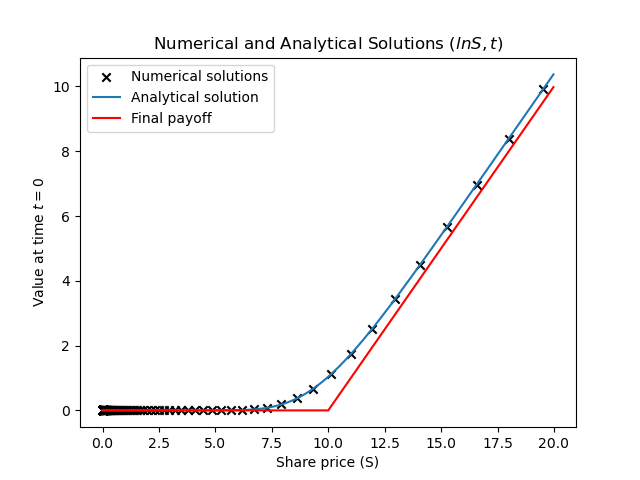

In [16]:
# solutions are of length 300 -> 300 grid points from 0-30, therefore take every tenth point instead
SplotN = Splot[::130]
VsolplotN = Vsolplot[::130]


plt.figure()
plt.scatter(SplotN, VsolplotN, marker='x', color = 'black', label='Numerical solutions')
plt.plot(Splot, Asolplot, label = 'Analytical solution')
plt.plot(Splot, ICplot, color='r', label='Final payoff')
plt.title('Numerical and Analytical Solutions $(lnS, t)$')
plt.xlabel('Share price (S)')
plt.ylabel('Value at time $t=0$')
plt.legend()
plt.show()

##### 2. Discretization errors over grid

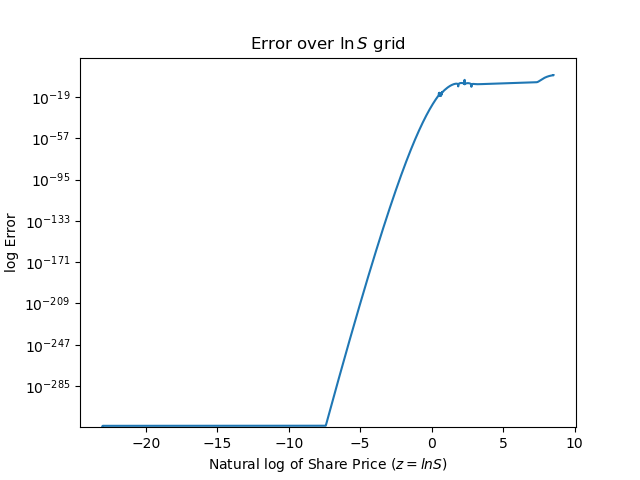

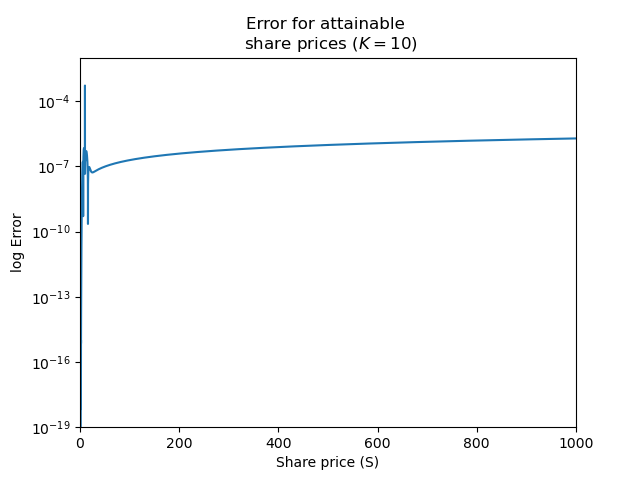

In [297]:
# Entire grid
plt.figure()
plt.semilogy(Z, AP3error[:,-1])
plt.title('Error over $\ln S$ grid')
plt.xlabel('Natural log of Share Price ($z = lnS$)')
plt.ylabel('log Error')
plt.show()


# Up to reasonable, but still practically unreachable S = 1000 (relative to strike price K = 10)
plt.figure()
plt.semilogy(np.exp(Z), AP3error[:,-1])
plt.title('Error for attainable \n share prices ($K=10$)')
plt.xlabel('Share price (S)')
plt.ylabel('log Error')
plt.xlim(0, 1000)
plt.ylim(1e-19, 1e-2)
plt.show()

# 3. Solution in Heat Equation Space (IN PROGRESS: how to incorporate changing Z grid?)

Using transformations:
- $V \rightarrow v = e^{-rt}V$

Thus, ${\partial V \over \partial t} = {\partial v \over \partial t}e^{rt} + {\partial e^{rt} \over \partial t}v = ({\partial v \over \partial t} + rv)e^{rt} \Rightarrow {\partial v \over \partial t} + {1 \over 2}\sigma^2S^2{\partial^2 v \over \partial S^2} + rS{\partial v \over \partial S} = 0$ is the new BS PDE

- $t \rightarrow \tau = T - t$

- $S \rightarrow z = \ln(S) - (r - {\sigma^2 \over 2})t$


Thus, 
- ${\partial v \over \partial t} = -{\partial v \over \partial \tau} - (r- {1 \over 2}\sigma^2){\partial v \over \partial z}$
- ${\partial v \over \partial S} = {1 \over S}{\partial v \over \partial z}$
- ${\partial^2 v \over \partial S^2} = {\partial \over \partial S}({\partial v \over \partial S}) = {\partial \over \partial S} ({1 \over S}{\partial v \over \partial z}) = {\partial \over \partial S}({1 \over S}){\partial v \over \partial z} + {1 \over S}{\partial \over \partial z}({\partial v \over \partial z}){\partial z \over \partial S} = -{1 \over S^2}{\partial v \over \partial z} + {1 \over S^2}{\partial^2 v \over \partial z^2}$

After substitution, the PDE is then:

${\partial v \over \partial t} = \frac{1}{2}\sigma^2 {\partial^2 v \over \partial z^2}$

with diffusion coefficient $\alpha = \frac{1}{2}\sigma^2$.

## Test Case

### Constant Parameters: $Z_{min} = , Z_{max} = , dZ = , dt = $

In [313]:
# defining variables
# FOR THE lnS space Black-Scholes PDE
### // Customizable // ###
iZ = 50000 # total number of grid steps along Z
Smin = 1e-10
Smax = 5000
# The Z values change over time, but have a constant spacing, use the tau = 0 time to calculate step size.
Zmin = np.log(Smin) # use t = 0 value
Zmax = np.log(Smax) # use t = 0 value

### // Fixed for Black-Scholes PDE problem// ###
dZ = (Zmax - Zmin)/float(iZ) # may need variable spacing as S boundary is so large (have more points for S near enough K)
Z = np.linspace(Zmin, Zmax, iZ + 1) # static z grid
dt = 0.01 # fixed time spacing seems reasonable
print(f'dz = {dZ} and dt = {dt}')

tau = 0 # start time (going forwards)
nt = int(T/dt) # number of steps in time

dz = 0.0006308608824271339 and dt = 0.01


### Initial and Boundary Conditions

In [314]:
# Initial and boundary conditions
vIC = np.maximum(np.exp(Z - 0.5 * sig**2 * T) - K*np.exp(-r*T), 0) # tau = 0, t = T

# Boundary values do not change
vB1 = 0
vB2 = Smax * np.exp(-r*T) # t = T initial condition

# Define solution matrix
v = np.zeros((iZ-1, nt+1)) # excluding boundary points


# add initial conditions in first column
v[:,0] = vIC[1:-1]
v[0,0] = vB1
v[-1,0] = vB2

### Solving the Tridiagonal System

In [315]:
t0 = time.time()
# Define tridiagonal system

# constants in system
R = dt * sig**2 / (4 * dZ**2)

# check diagonal dominance for thomas algorithm stability
print(f'lower diag values = {-R}')
print(f'diag values = {1 + 2*R}')
print(f'upper diag values = {-R}')

# vectors of tridiagonal
a = np.ones(iZ-1) * -R # lower diag
b = np.ones(iZ-1) * (1 + 2*R) # diag now (1 + bc)
c = np.ones(iZ-1) * -R # upper diag

# empty RHS vector
d = np.zeros(iZ-1)


vB2s = [vB2]

# iterate over time (note now middle element has (1 - bc))
for j in range(1, nt+1):
    # upper boundary value changes over time
    vB2 = Smax * np.exp(-r*(T - j*dt))
    vB2s.append(vB2)
    
    # left boundary
    d[0] = (R*vB1 + (1 - 2*R)*v[0,j-1] + R*v[1,j-1]) + R*vB1
    # no boundaries involved
    d[1:-1] = (R*v[0:-2,j-1] + (1 - 2*R)*v[1:-1,j-1] + R*v[2:,j-1])
    # right boundary
    d[-1] = (R*v[-2,j-1] + (1 - 2*R)*v[-1,j-1] + R*vB2) + R*vB2 #problematic
    
    # store solution
    v[:,j] = TDMA(a,b,c,d)
    
t1 = time.time()

print(f'\n Execution time: {t1-t0}s')

lower diag values = -141.33682419615275
diag values = 283.6736483923055
upper diag values = -141.33682419615275
Execution time: 15.095479488372803s


In [276]:
# Add Boundary Conditions
v0 = np.array([vB1]*(nt+1))
viZ = np.array(vB2s)
vsol = np.vstack((v0, v, viZ)) # adds V0 as row to top and ViZ as row to bottom

In [277]:
Vsol = np.zeros((iZ+1, nt+1))

# Transforming back to value V = e^(rt)v
for j in range(nt+1):
    Vsol[:, j] = np.exp(r*(T - j*dt))*vsol[:, j]

### Plotting Results

#### $(z, \tau)$ Space

In [278]:
# Simnply plot solutions on Z grid point from Zmin to Zmax fixed.


#### $(S, \tau)$ Space

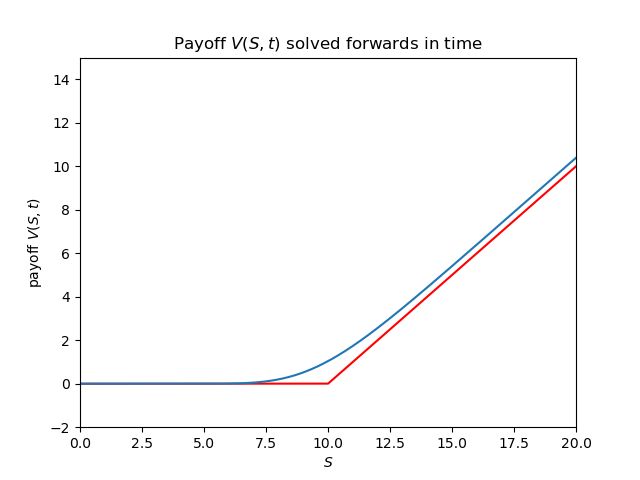

In [279]:
# Recall
Z = np.linspace(Zmin, Zmax, iZ + 1)
# Re-transformed initial conditions
VIC = np.exp(r*T)*vIC

# initialise plot
fig = plt.figure()
animation_camera = celluloid.Camera(fig)

S = np.zeros((iZ+1, nt+1))

# Get corresponding S for each time
for n in range(nt+1):
    S_n = np.exp(Z + (r - 0.5*sig**2)*(T - n*dt)) # tau_j = j*dt
    S[:,n] = S_n
    
    V_n = Vsol[:,n]
    plt.ylim(-2, 15)
    plt.xlim(0, 20)
    plt.plot(S[:,0], VIC, color='r') # initial condition
    plt.plot(S_n, V_n)
    plt.title('Payoff $V(S, t)$ solved forwards in time')
    plt.xlabel('$S$')
    plt.ylabel('payoff $V(S, t)$')
    animation_camera.snap()
    

animation = animation_camera.animate() 
animation.save('BSEuropeanCall-Diffusion-Sspace.mp4')

### Discretization Errors ($t=0$ present time valuation)

#### Error Matrix

In [280]:
# Discretization error matrix
P5error = DErrors_D(Vsol, Z, dt=dt, nt=nt)

In [281]:
# Absolute Discretization error matrix
AP5error = np.abs(P5error)

#### Error metrics

##### 1. Considering entire $Z \equiv S$ domain

In [282]:
# Absolute final error values
finErr5 = np.abs(P5error[:,-1])
# MAX ERROR
max_error5 = np.max(finErr5)
print(f'The maximal error is: \n {max_error5}')
max_error_ind5 = np.where(finErr5 == max_error5)[0][0]
print(f'The max error is located at {max_error_ind5}, corresponding to a z value of {Zmin + max_error_ind5*dZ}, and S value of {np.exp(Zmin + max_error_ind5*dZ)} \n')


# Absolute error for each time
abs_error5 = np.sum(finErr5)
print(f'The absolute sum of errors is: \n {abs_error5}')

The maximal error is: 
 17.77499830751185
The max error is located at 49998, corresponding to a z value of 8.515931469651381, and S value of 4993.695369356953 

The absolute sum of errors is: 
 5471.35233465669


##### 2. Considering realistically attainable $Z \equiv S$ domain

In [283]:
# Define a cutoff at a large enough S and corresponding Z
Scut = 1000
Zcut = np.log(1000)
cutoff = int((Zcut - Zmin) / dZ)

real_finErr5 = finErr5[:cutoff]
real_max_error5 = np.max(real_finErr5)
print(f'The maximal error is: \n {real_max_error5}')

real_max_error_ind5 = np.where(real_finErr5 == real_max_error5)[0][0]
print(f'The max error is located at {real_max_error_ind5}, corresponding to a z value of {Zmin + real_max_error_ind5*dZ}, and S value of {np.exp(Zmin + real_max_error_ind5*dZ)} \n')


# Absolute error for each time
real_abs_error5 = np.sum(real_finErr5)
print(f'The absolute sum of errors is: \n {real_abs_error5}')


The maximal error is: 
 0.00031300812990830984
The max error is located at 40121, corresponding to a z value of 2.2849185339185816, and S value of 9.82488579646774 

The absolute sum of errors is: 
 0.002398010850480202


#### Error plots

##### 1. Numerical and Analytic Solution

In [284]:
Asol = BSa_D(Z, dt=dt, nt=nt)
AsolCurr = Asol[:,-1]
VsolCurr = Vsol[:,-1]

In [285]:
# Define a cutoff corresponding to around two times the strike price
cutoff = int((np.log(2*K) - Zmin)/dZ)
# Get the final iteration present time S, retransformed from z for t = 0, cutoff as defined above
Splot = S[:,-1][:cutoff]

# Cut off the final iteration present time numerical and analytical valuations
Vsolplot = VsolCurr[:cutoff]
Asolplot = AsolCurr[:cutoff]

# Define the 'initial' condition S grid retransformed for t = T and cutoff, with value given by final payoff. 
SIC = S[:,0][:cutoff]
ICplot = VIC[:cutoff]

# Note that the S grid effectively shifts left as the solution propagates backwards in time due to the + (r - 0.5sig^2)t term
# as t = T -> t = 0 via backward solution.

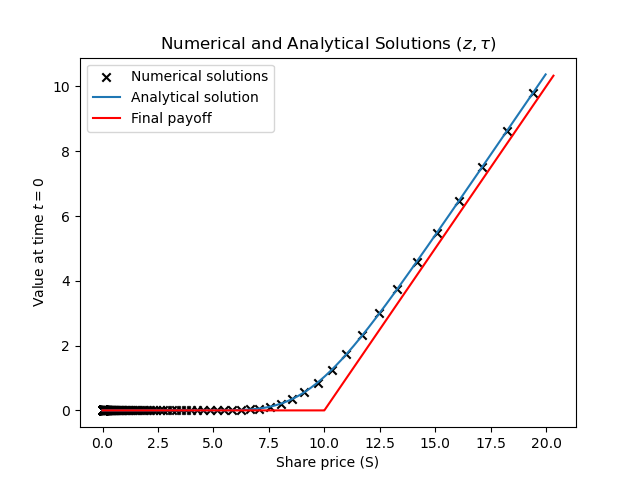

In [288]:
# solutions are of length 300 -> 300 grid points from 0-30, therefore take every tenth point instead
SplotN = Splot[::100]
VsolplotN = Vsolplot[::100]


plt.figure()
plt.scatter(SplotN, VsolplotN, marker='x', color = 'black', label='Numerical solutions')
plt.plot(Splot, Asolplot, label = 'Analytical solution')
plt.plot(SIC, ICplot, color='r', label='Final payoff')
plt.title('Numerical and Analytical Solutions $(z, \\tau)$')
plt.xlabel('Share price (S)')
plt.ylabel('Value at time $t=0$')
plt.legend()
plt.show()

##### 2. Discretization errors over grid

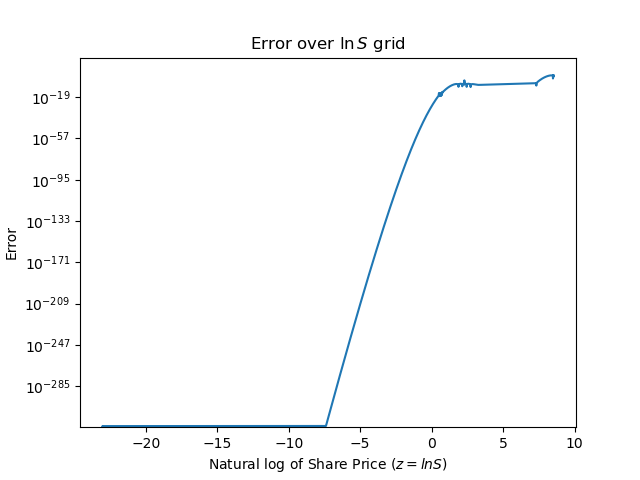

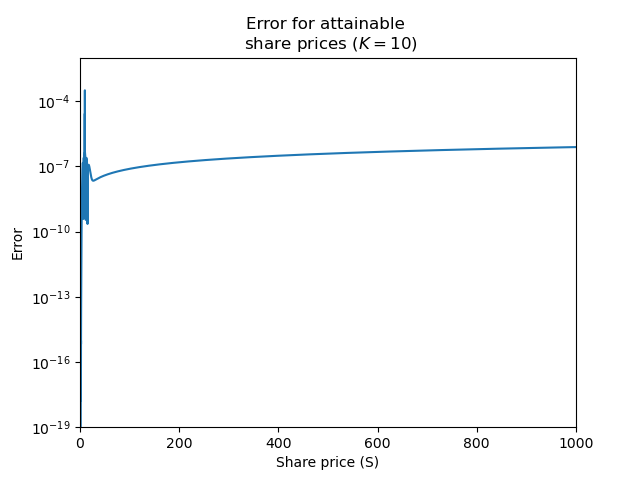

In [300]:
# Entire grid
plt.figure()
plt.semilogy(Z, AP5error[:,-1])
plt.title('Error over $\ln S$ grid')
plt.xlabel('Natural log of Share Price ($z = lnS$)')
plt.ylabel('Error')
plt.show()


# Up to reasonable, but still practically unreachable S = 1000 (relative to strike price K = 10)
plt.figure()
plt.semilogy(np.exp(Z + (r - 0.5*sig**2)*0), AP5error[:,-1])
plt.title('Error for attainable \n share prices ($K=10$)')
plt.xlabel('Share price (S)')
plt.ylabel('Error')
plt.xlim(0, 1000)
plt.ylim(1e-19, 1e-2)
plt.show()